In [2]:
import tensorflow as tf
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
import warnings
import tqdm
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Loading model

In [4]:
# Load graph data
loader = tf.train.import_meta_graph('saved_model/classifier.ckpt.meta')
sess = tf.Session()
loader.restore(sess,'saved_model/classifier.ckpt')
graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from saved_model/classifier.ckpt


In [84]:
# Find relevant ops
assert len([op.name for op in graph.get_operations() if 'output' in op.name or 'input' in op.name]) == 2
assert len([op.name for op in graph.get_operations() if 'cnn_' in op.name]) == 0

AssertionError: 

In [5]:
# Grab them
x = graph.get_tensor_by_name('features:0')
y = graph.get_tensor_by_name('output:0')

# Testing model accuracy (just in case)

In [6]:
test_image = skimage.transform.resize(plt.imread('train/dog.0.jpg'), (128,128,1))
res = sess.run(y, feed_dict={x: [test_image]})
answer = 'cat' if res[0][0]>res[0][1] else 'dog'
print(f'{res[0]} - {answer}')

[0.26894182 0.7310582 ] - dog


In [7]:
def calculate_accuracy():
    counter = 0
    for i in tqdm.trange(1000):
        animal = 'cat' if i%2==0 else 'dog'
        test_image = skimage.transform.resize(plt.imread(f'train/{animal}.{i}.jpg'), (128,128,1))
        res = sess.run(y, feed_dict={x: [test_image]})
        answer = 'cat' if res[0][0]>res[0][1] else 'dog'
        if answer == animal:
            counter+=1
    return counter
      
counter = calculate_accuracy()
print(f'{counter/10}% accuracy')

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.30it/s]


87.0% accuracy


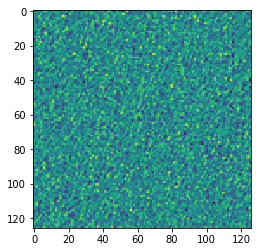

In [8]:
def T(layer):
    return graph.get_tensor_by_name(f'{layer}:0')

inp = T('cnn/classificator/convolution/deep_dreaming_input/Conv2D')

img = np.random.uniform(size=(1,128,128,3)) + 100.0
res = sess.run(T('cnn/classificator/convolution/conv2d/Conv2D'), feed_dict={inp: img})
# res.T.shape
res = res/np.max(res)
plt.imshow(res[0,:,:,3])

# Dreaming!

In [9]:
print([op.name for op in graph.get_operations() if 'Conv2D' in op.name and 'training' not in op.name])
# print([op.name for op in graph.get_operations() if 'output' in op.name and 'training' not in op.name])

['cnn/classificator/convolution/deep_dreaming_input/Conv2D', 'cnn/classificator/convolution/conv2d/Conv2D', 'cnn/classificator/convolution/conv2d_1/Conv2D', 'cnn/classificator/convolution/conv2d_2/Conv2D', 'cnn/classificator/convolution/conv2d_3/Conv2D', 'cnn/classificator/convolution/conv2d_4/Conv2D']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


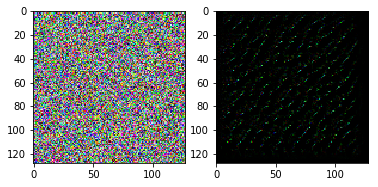

In [86]:
layer = 'cnn/classificator/convolution/conv2d_2/Conv2D'
feature = 32

# np.random.seed(0)
img_noise = np.random.random(size=(1,128,128,3))

def showarray(a, fmt='jpeg'):
    a = a/np.max(a)
    plt.imshow(a[0])

def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj)
    t_grad = tf.gradients(t_obj, inp)[0]
    
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {inp:img})
        
        g /= g.std()+1e-8         
        img += g*step
    showarray(img)
        
    return img

op = T(layer)
plt.subplot(121)
plt.imshow(img_noise[0])
plt.subplot(122)
img = render_naive(op[:,:,:,feature])

In [109]:
def dream_image(img0, t_obj, feature, iter_n=20, step=1.0, bw=False, random=False):
    t_obj = t_obj[:,:,:,feature]
    entry_point = x if bw else inp
    if random and bw:
        img0 = np.random.random(size=(1,128,128,1))
    elif random:
        img0 = np.random.random(size=(1,128,128,3))
    
    t_score = tf.reduce_mean(t_obj)
    t_grad = tf.gradients(t_obj, entry_point)[0]
    
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {entry_point:img})
        
        g /= g.std()+1e-8         
        img += g*step
        
    if bw:
        img = img[0,:,:,0]
    else:
        img = img[0]
        
    return img/np.max(img)

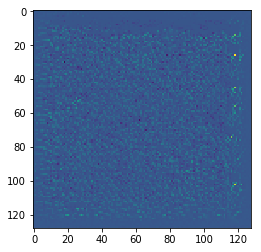

In [52]:
img = dream_image(None, T('cnn/classificator/convolution/conv2d_2/Conv2D'), 20, random=True, bw=True)
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


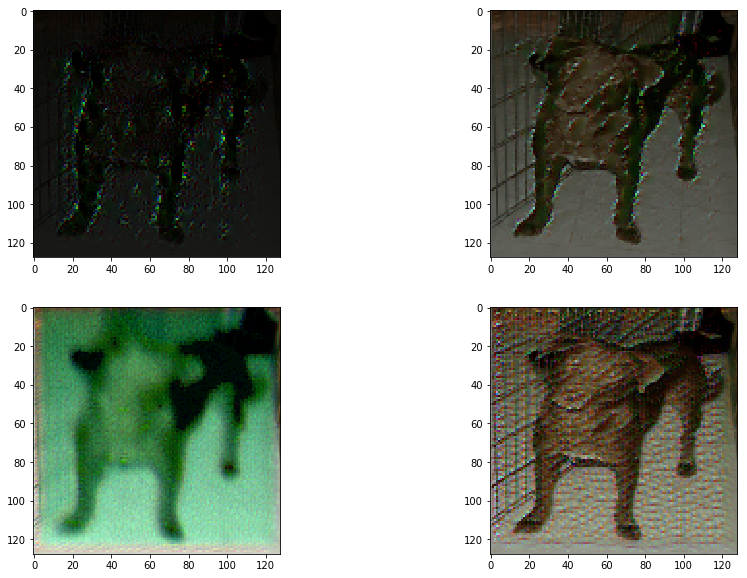

In [127]:
img = plt.imread(f'train/dog.1.jpg')
img = skimage.transform.resize(img, (128, 128, 3))
img = img/np.max(img)

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_3/Conv2D'), 15, step=0.05));
plt.subplot(222)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_2/Conv2D'), 30, step=0.01));
plt.subplot(223)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_1/Conv2D'), 20, step=0.05));
plt.subplot(224)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_1/Conv2D'), 15, step=0.01));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


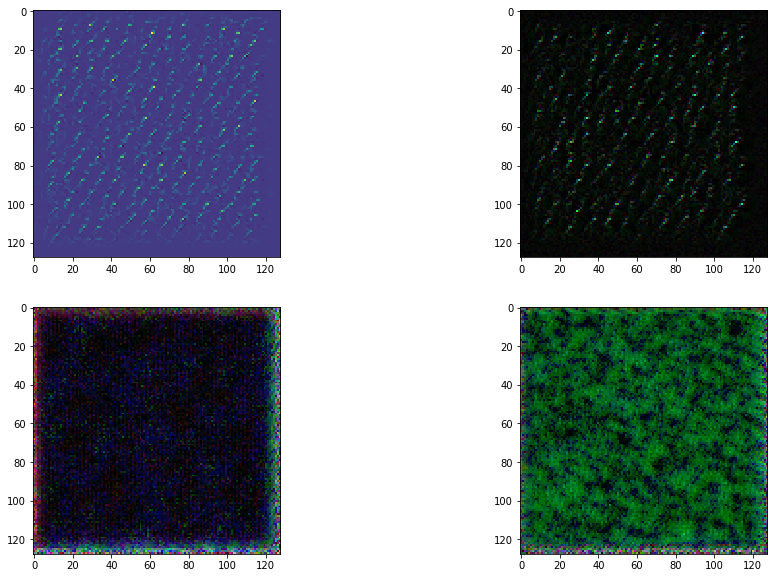

In [125]:
plt.figure(figsize=(16,10))
plt.subplot(221)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_2/Conv2D'), 40, step=1, random=True, bw=True))
plt.subplot(222)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_2/Conv2D'), 40, step=0.1, random=True))
plt.subplot(223)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_1/Conv2D'), 32, step=0.1, random=True))
plt.subplot(224)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_1/Conv2D'), 10, step=0.1, random=True))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


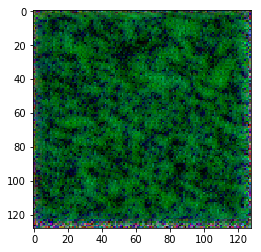

In [124]:
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_1/Conv2D'), 10, step=0.1, random=True))

[[0.26894143 0.7310586 ]]
[[0.26894143 0.7310586 ]]


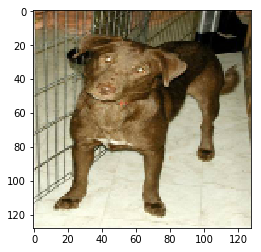

In [91]:
img = plt.imread(f'train/dog.1.jpg')
img = skimage.transform.resize(img, (128, 128, 3))
img = img/np.max(img)

op = T('output')
purified = render_naive(op, img0=[img], iter_n=20, step=1);
print(sess.run(y, {inp:purified}))
print(sess.run(y, {inp:[img]}))

[[0.26894143 0.7310586 ]]


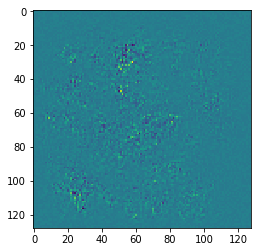

In [105]:
t_obj = T('output')
t_obj = t_obj[:,1]
entry_point = x

img0 = np.random.uniform(size=(1,128,128,1))
img = [img]
t_score = tf.reduce_mean(t_obj)
t_grad = tf.gradients(t_obj, entry_point)[0]

img = img0.copy()
for i in range(100):
    g, score = sess.run([t_grad, t_score], {entry_point:img})

    g /= g.std()+1e-8         
    img += g*1

print(sess.run(y, {x:img}))    
img = img[0,:,:,0]
    
plt.imshow(img)

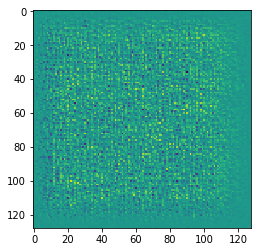

In [153]:
t_obj = T('cnn/classificator/convolution/conv2d_2/Conv2D')[:,:,:,3]
t_score = tf.reduce_mean(t_obj)
t_grad = tf.gradients(t_obj, x)[0]

img_noise = np.random.random(size=(1,128,128,1))

for i in range(20):
    g, score = sess.run([t_grad, t_score], {x:img_noise})

    g /= g.std()+1e-8         
    img_noise += g*1.0

showarray(norm(img_noise)[:,:,:,0])